# Qamomile v0.8.0

---

このリリースでは、[日本語のチュートリアル](https://jij-inc.github.io/Qamomile/ja/)（Bloqade-Analog向けの新しいチュートリアルを含む）を追加することで、より幅広いユーザーのアクセシビリティを大幅に向上させ、[OMMX v2](https://jij-inc.github.io/ommx/en/introduction.html)をサポートすることで使いやすさを改善し、新しい量子SDK[CUDA-Q](https://developer.nvidia.com/cuda-q)のサポートを導入しました。また、[Qiskit](https://github.com/Qiskit/qiskit) v2への対応も行いました。特にOMMX v2のサポートは、最適化問題の統一フォーマットを提供することで、量子最適化アルゴリズムと古典的ソルバーの比較を従来よりも簡単に行えるようになるため、私たちとユーザーの両方にとって特に重要であると考えています。

また、やや小さな影響のあるその他のアップデートも含まれています。詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)や個々のPRをご確認ください。

## ✨ 新機能

### OMMX v2 サポート ([#126](https://github.com/Jij-Inc/Qamomile/pull/126), [#198](https://github.com/Jij-Inc/Qamomile/pull/198))

OMMX v2は、従来のProtocol Bufferベースのアプローチに代わる新しいRustベースの実装により、大幅な性能向上をもたらします（詳細は[OMMX Python SDK 2.0.0](https://github.com/Jij-Inc/ommx/blob/main/docs/ja/release_note/ommx-2.0.0.md)を参照）。このアップデートでは以下が提供されます：

  - **性能向上**: 特に大規模問題における計算量の複雑さの改善
  - **APIの改善**: より直感的でAIに優しいAPI設計
  - **型安全性の向上**: より堅牢な最適化問題処理のためのRustレベルの型チェック

注意点として、OMMX v2はインスタンス処理の性能向上をもたらしますが、回路の実行時間などの量子アルゴリズム側の性能向上を意味するものではありません。

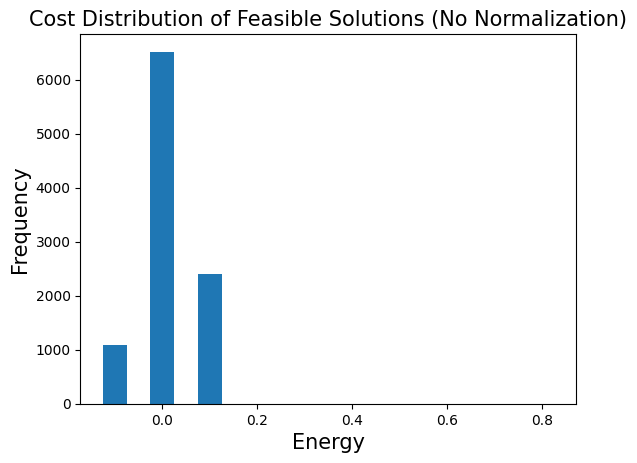

In [1]:
# 必要なライブラリをインポート
from collections import defaultdict

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile.core as qm
import qamomile.qiskit as qm_qk


# JijModelingで最適化問題を作成
Q = jm.Placeholder("Q", ndim=2)
n = Q.len_at(0, latex="n")
x = jm.BinaryVar("x", shape=(n,))

problem = jm.Problem("qubo")
i, j = jm.Element("i", n), jm.Element("j", n)
problem += jm.sum([i, j], Q[i, j] * x[i] * x[j])

# データをommx.v1.Instanceとしてコンパイル
instance_data = {"Q": [[0.1, 0.2, -0.1], [0.2, 0.3, 0.4], [-0.1, 0.4, 0.0]]}
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)  # 新機能

# QamomileでQAOAに変換
qaoa_converter = qm.qaoa.QAOAConverter(instance)
p = 5
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

# Qamomileの回路とハミルトニアンをQiskit形式に変換
qk_transpiler = qm_qk.QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# Qiskit primitivesを使用してコスト推定関数を定義
estimator = qk_pr.StatevectorEstimator()
cost_history = []
def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"コスト推定中にエラーが発生しました: {e}")
        return np.inf

# COBYLAを使用してQAOAパラメータを最適化
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)

# 最適化されたパラメータでQAOA回路を実行
qk_circuit.measure_all()
sampler = qk_pr.StatevectorSampler()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
sampleset: ommx.v1.SampleSet = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])  # 新機能

# エネルギーをグループ化してその頻度を数える辞書を作成
energy_freq = defaultdict(int)
for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1
energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

# コスト分布を表示
plt.bar(energies, frequencies, width=0.05)
plt.title("Cost Distribution of Feasible Solutions (No Normalization)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

### CUDA-Q サポート ([#143](https://github.com/Jij-Inc/Qamomile/pull/143))
CUDA-Qは、ハイブリッドアプリケーション開発を合理化し、量子コンピューティングにおける生産性とスケーラビリティを促進します。そして今、QamomileフォーマットのCircuitやHamiltonianをCUDA-Qフォーマットにコンパイルできるようになりました！

残念ながら現在CUDA-QそのものがLinux OSのみをサポートしているため，QamomileでもCUDA-Qサポート機能はLinux OSのみを対象としていることをご注意ください．

In [2]:
import cudaq

from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.operator import Hamiltonian, X, Y, Z
from qamomile.cudaq.transpiler import CudaqTranspiler

# CudaqTranspilerのインスタンスを作成
cudaq_transpiler = CudaqTranspiler()

# Qamomileを使用してシンプルな量子回路を定義
qc = QamomileCircuit(1)
qc.h(0)
qc.x(0)

# CudaqTranspilerを使用して回路をTranspile
transpiled_circuit = cudaq_transpiler.transpile_circuit(qc)

# Transpileされた回路を描画
print(type(transpiled_circuit))
print(cudaq.draw(transpiled_circuit, []))

# Qamomileを使用してハミルトニアンを作成
hamiltonian = Hamiltonian()
hamiltonian += X(0) * Z(1)
hamiltonian += Y(0) * Y(1) * Z(2) * X(3) * X(4)

# CudaqTranspilerを使用してハミルトニアンをTranspile
transpiled_hamiltonian = cudaq_transpiler.transpile_hamiltonian(hamiltonian)
# Transpileされたハミルトニアンを表示
print(type(transpiled_hamiltonian))
print(transpiled_hamiltonian)

<class 'cudaq.kernel.kernel_builder.PyKernel'>
     ╭───╮╭───╮
q0 : ┤ h ├┤ x ├
     ╰───╯╰───╯

<class 'cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.SpinOperator'>
(0+0i) + (1+0i) * X0Z1 + (1+0i) * Y0Y1Z2X3X4


### Qiskit v2 サポート ([#194](https://github.com/Jij-Inc/Qamomile/pull/194))
Qiskitのメジャーアップデートに合わせてQamomileでもQiskit v2のサポートを行いました。

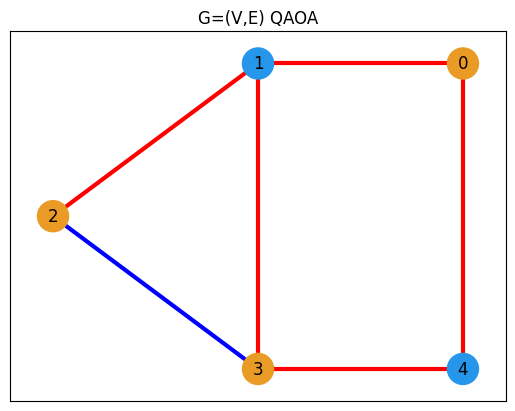

In [3]:
# 必要なライブラリをインポート
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.qiskit.transpiler import QiskitTranspiler

# Maxcut問題を定義
V = jm.Placeholder("V")
E = jm.Placeholder("E", ndim=2)
x = jm.BinaryVar("x", shape=(V,))
e = jm.Element("e", belong_to=E)
i = jm.Element("i", belong_to=V)
j = jm.Element("j", belong_to=V)

problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
si = 2 * x[e[0]] - 1
sj = 2 * x[e[1]] - 1
si.set_latex("s_{e[0]}")
sj.set_latex("s_{e[1]}")
obj = 1 / 2 * jm.sum(e, (1 - si * sj))
problem += obj

# 問題をデータとともにommx.v1.Instanceとしてコンパイル
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
E = [list(edge) for edge in G.edges]
instance_data = {"V": G.number_of_nodes(), "E": E}
compiled_instance: ommx.v1.Instance = jm.Interpreter(instance_data).eval_problem(problem)

# コンパイルした問題をQAOA形式へ変換する
qaoa_converter = QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

# QAOAハミルトニアンと回路を取得
p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

# QAOA回路とハミルトニアンをQiskit用へ変換する
transpiler = QiskitTranspiler()
qk_circuit = transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# コスト推定関数
cost_history = []
estimator = qk_pr.StatevectorEstimator()
def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data.evs  # Qiskit v2推奨アクセス方法
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf

# QAOA最適化を実行する
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000},
)

# 最適化されたQAOA回路を実行する
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data.meas  # Qiskit v2推奨アクセス方法

# 最適解を取得する
sampleset = qaoa_converter.decode(transpiler, qaoa_counts)
best_values = sampleset.best_feasible_unrelaxed.extract_decision_variables("x")

# 辺の色と点の色を取得する
def get_edge_colors(graph, cut_solution, in_cut_color="r", not_in_cut_color="b"):
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors
edge_colors, node_colors = get_edge_colors(G, best_values)

# グラフを描画する
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(G, pos, node_size=500, width=3, with_labels=True, edge_color=edge_colors, node_color=node_colors)

## 🐛 バグ修正

詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)をご確認ください。

## 🛠️ その他の変更と改善

詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)をご確認ください。

## 💬 フィードバック
これらの新機能により、Qamomileは複数の量子SDKに同じ方法でアクセスし、古典的ソルバーと結果を比較できる強力なツールになりました。Qamomile 0.8.0をぜひお試しください！


フィードバックやバグ報告は、[GitHub Issues](https://github.com/Jij-Inc/Qamomile/issues)にお送りください。